In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
import helper_functions (1)
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

In [2]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [7]:
dataset = "D:/gp/kaggle2/Agricultural pest image dataset.zip (new)"
walk_through_dir(dataset)

NameError: name 'walk_through_dir' is not defined

In [35]:
!unzip "/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: ants/ants (95).jpg      
  inflating: ants/ants (96).jpg      
  inflating: ants/ants (97).jpg      
  inflating: ants/ants (98).jpg      
  inflating: ants/ants (99).jpg      
  inflating: bees/bees (1).jpg       
  inflating: bees/bees (10).jpg      
  inflating: bees/bees (100).jpg     
  inflating: bees/bees (101).jpg     
  inflating: bees/bees (102).jpg     
  inflating: bees/bees (103).jpg     
  inflating: bees/bees (104).jpg     
  inflating: bees/bees (105).jpg     
  inflating: bees/bees (106).jpg     
  inflating: bees/bees (107).jpg     
  inflating: bees/bees (108).jpg     
  inflating: bees/bees (109).jpg     
  inflating: bees/bees (11).jpg      
  inflating: bees/bees (110).jpg     
  inflating: bees/bees (111).jpg     
  inflating: bees/bees (112).jpg     
  inflating: bees/bees (113).jpg     
  inflating: bees/bees (114).jpg     
  inflating: bees/bees (115).jpg     
  inflating: bees/bees (116).jpg     

In [36]:
dataset = "/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)"
walk_through_dir(dataset)

There are 12 directories and 0 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)'.
There are 0 directories and 498 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/wasp'.
There are 0 directories and 485 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/grasshopper'.
There are 0 directories and 416 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/beetle'.
There are 0 directories and 499 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/ants'.
There are 0 directories and 497 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/moth'.
There are 0 directories and 485 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/weevil'.
There are 0 directories and 500 images in '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/bees'.
The

In [37]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [38]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

<ipython-input-39-e73ce97afbc1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


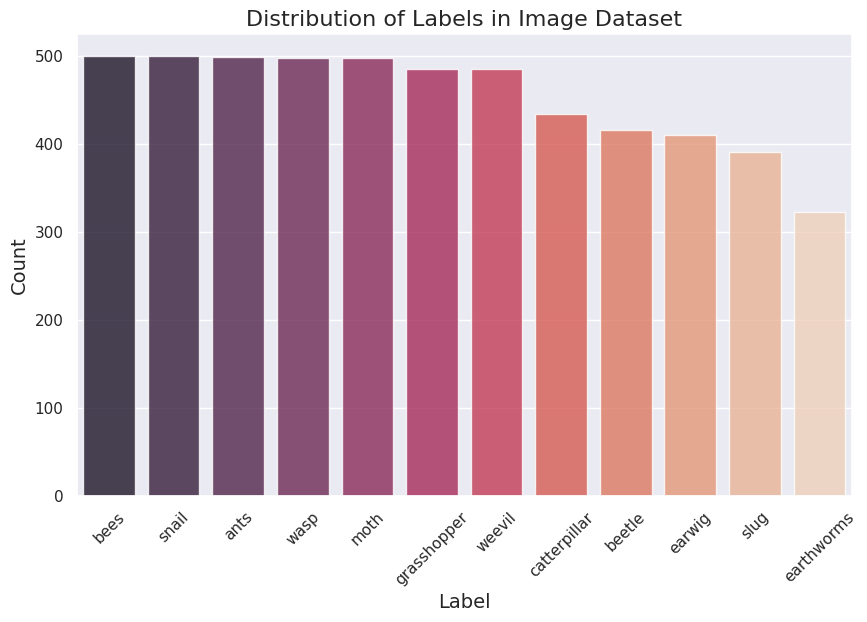

In [39]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()


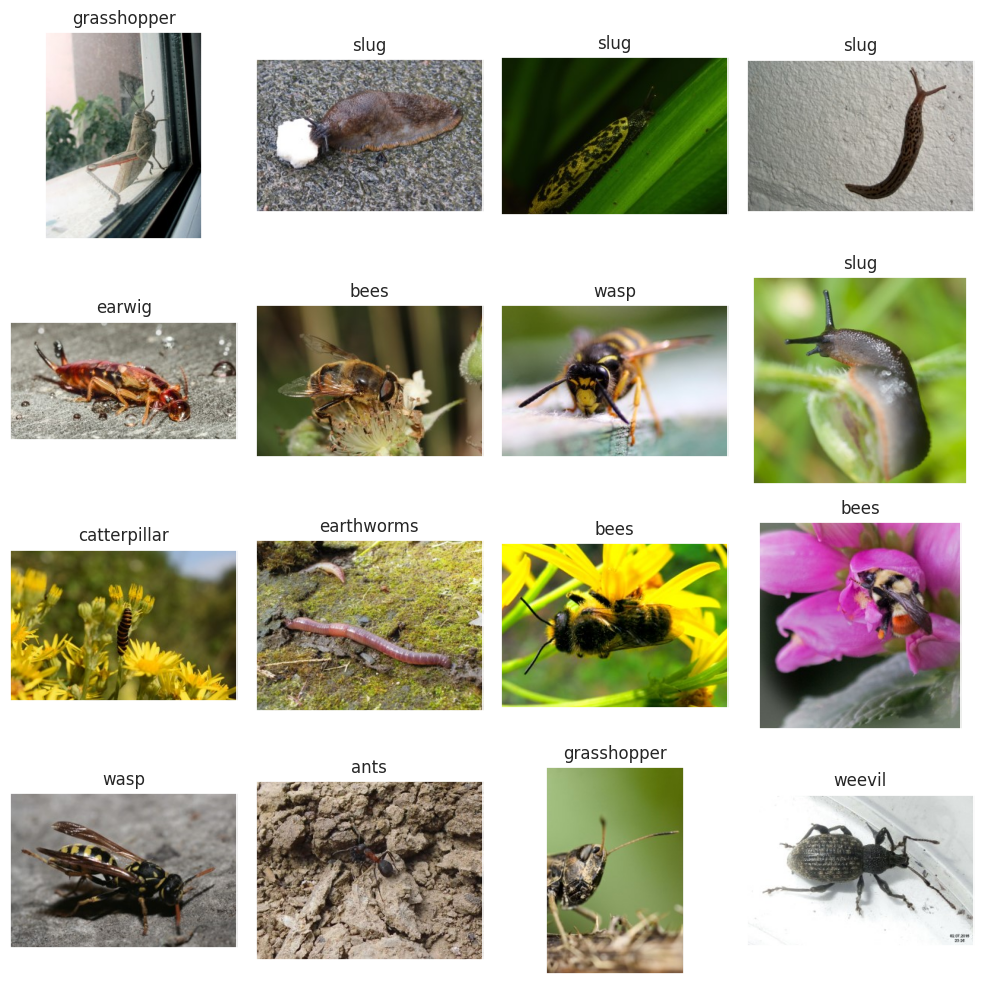

In [40]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [41]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

In [42]:
# View random sample from the dataset
p = random_sample('/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/ants')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [43]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [44]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [45]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3480 validated image filenames belonging to 12 classes.
Found 870 validated image filenames belonging to 12 classes.
Found 1088 validated image filenames belonging to 12 classes.


In [46]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [47]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

473176280/473176280 [==============================] - 22s 0us/step


In [48]:
# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [49]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath to save the model
checkpoint_filepath = 'model_checkpoint.h5'

# Create a ModelCheckpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,  # Path to save the model
    save_best_only=True,           # Save only the best model
    monitor='val_accuracy',        # Monitor validation accuracy
    mode='max',                    # Save the model with the highest validation accuracy
    verbose=1                      # Show messages about the saving process
)

# Define the model architecture and compile it
inputs = pretrained_model.input
x = augment(inputs)

# Add new classification layers
x = Flatten()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with callbacks
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=120,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "pests_cats_classification"),
        checkpoint_callback,
    ]
)


Saving TensorBoard log files to: training_logs/pests_cats_classification/20240624-033728
Epoch 1/120
109/109 [==============================] - ETA: 0s - loss: 3.2003 - accuracy: 0.0934
Epoch 1: val_accuracy improved from -inf to 0.18851, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - 112s 655ms/step - loss: 3.2003 - accuracy: 0.0934 - val_loss: 2.3858 - val_accuracy: 0.1885
Epoch 2/120
109/109 [==============================] - ETA: 0s - loss: 2.9889 - accuracy: 0.1190
Epoch 2: val_accuracy improved from 0.18851 to 0.29425, saving model to model_checkpoint.h5
109/109 [==============================] - 68s 625ms/step - loss: 2.9889 - accuracy: 0.1190 - val_loss: 2.2178 - val_accuracy: 0.2943
Epoch 3/120
109/109 [==============================] - ETA: 0s - loss: 2.8110 - accuracy: 0.1511
Epoch 3: val_accuracy improved from 0.29425 to 0.37011, saving model to model_checkpoint.h5
109/109 [==============================] - 58s 534ms/step - loss: 2.8110 - accuracy: 0.1511 - val_loss: 2.0973 - val_accuracy: 0.3701
Epoch 4/120
109/109 [==============================] - ETA: 0s - loss: 2.6609 - accuracy: 0.1816
Epoch 4: val_accuracy improved from 0.37011 to 0.42414, saving model to model_checkpoint.h5
109/109 [=====================

In [51]:
import os

# Define the path
save_path = r"/content/gdrive/MyDrive/kaggle2/saved_model/trained_model.h5"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
model.save(save_path)


In [1]:
from tensorflow.keras.models import load_model

In [61]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os

# List files in the directory where your model is stored
model_dir = 'D:\gp\kaggle2\saved_model'
print(os.listdir(model_dir))

['trained_model.h5']


In [3]:
model_path = 'D:/gp/kaggle2/saved_model/trained_model.h5'
if os.path.exists(model_path):
    loaded_model = load_model(model_path)
    print("Model loaded successfully!")
else:
    print(f"No file found at {model_path}")



Model loaded successfully!


In [4]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling_1[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                           

In [60]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

OSError: [Errno 107] Transport endpoint is not connected: '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/bees/bees (364).jpg'

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

Model loaded successfully!


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/gp/kaggle2/test_images'

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/gdrive/MyDrive/kaggle2/Agricultural pest image dataset.zip (new)/bees/bees (364).jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as per your model's input


In [ ]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize the image if required by the model
img_array = img_array / 255.0


In [ ]:
predictions = model.predict(img_array)


In [ ]:

# Assuming you have a list of class names
class_names = ['bees', 'ants', 'beetle', 'caterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']  # Replace with your actual class names

predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions)

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")
